In [3]:
# Import libraries
import matplotlib.pyplot as plt
import random
import pathfinding
from pathfinding.core.grid import Grid
from pathfinding.finder.dijkstra import DijkstraFinder
from pathfinding.finder.bi_a_star import BiAStarFinder
from pathfinding.finder.best_first import BestFirst

In [4]:
# Node Class
class Node ():
    def __init__(self, parent = None, position = None, direction = None):
        self.parent = parent
        self.position = position
        self.direction = direction
        
        self.g = 0
        self.h = 0
        self.f = 0
        self.t = 0 # turning cost
    
    def __eq__(self, other):
        return self.position == other.position

In [5]:
# calculate turning cost
# note: down: x positive, right: y positive 
# global variable

operations_count = 0

In [6]:
def astar(maze, start, end, turning): 
    global operations_count
    STEP_COST = 1
    
    start_node = Node(None, start, (-1, 0))  # The AGV is facing down 
    start_node.g = start_node.f = start_node.h = start_node.t = 0
    
    end_node = Node(None, end) 
    end_node.g = end_node.h = end_node.f = end_node.t = 0
    
    open_list = []
    closed_list = []
    
    open_list.append(start_node)
    
   
    
    # Start the searching loop
    while len(open_list) > 0:
        # Get the current node (with the least f score)
        current_node = open_list[0]
        current_index = 0
        
        for index, node in enumerate(open_list):
            if node.f < current_node.f:
                current_node = node
                current_index = index
        
        # Pop the current node out of the open list and add to closed list
        open_list.pop(current_index)
        closed_list.append(current_node)
        
        # Check if the current node is the goal
        if current_node == end_node:
            path = []  # Contain the path from start to end node
            
            while current_node is not None:
                path.append(current_node.position)
                current_node = current_node.parent
                
            return path[::-1]
        
        # Generate neighbor nodes from current node
        neighbors = []
        operations_count += 1  # Increment the counter for each node evaluated
        for new_position in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
            node_position = (current_node.position[0] + new_position[0], current_node.position[1] + new_position[1])
            
            # Check if the new node is out of bounds
            if (node_position[0] > (len(maze) - 1) or 
                node_position[0] < 0 or 
                node_position[1] > (len(maze[len(maze)-1]) - 1) or 
                node_position[1] < 0):
                continue
            
            # Make sure walkable terrain
            if maze[node_position[0]][node_position[1]] != 0:
                continue
            
            # Create new node
            new_node = Node(current_node, node_position, new_position)  # New position is added for the current direction of that node

            neighbors.append(new_node)
            
        # Loop through children
        for neighbor in neighbors:
            if neighbor in closed_list:
                continue
            
            # Create the f, g, t and h values
            
            # Calculate turning cost 
            if (current_node.direction == neighbor.direction):
                neighbor.t = 0
            else: 
                neighbor.t = 1
                
            neighbor.g = current_node.g + STEP_COST
            neighbor.h = ((neighbor.position[0] - end_node.position[0])**2 + (neighbor.position[1] - end_node.position[1])**2)**0.5
            
            if (turning == 0):
                neighbor.f = neighbor.g + neighbor.h 
            else:
                neighbor.f = neighbor.g + neighbor.h + neighbor.t
                    
            # Skip if the neighbor is in the open list with a higher or equal f value
            if any(
                neighbor.position == open_node.position and neighbor.f >= open_node.f
                for open_node in open_list
            ):
                continue
                
            open_list.append(neighbor)
    
    return None  # If no path is found


In [7]:
def turns_counter(path):
    if len(path) < 3:
        return 0  # Not enough points to form a turn

    turns = 0

    for i in range(1, len(path) - 1):
        # Get the current point and the previous and next points
        p_prev = path[i - 1]
        p_curr = path[i]
        p_next = path[i + 1]

        # Calculate directions
        direction1 = (p_curr[0] - p_prev[0], p_curr[1] - p_prev[1])  # Direction from previous to current
        direction2 = (p_next[0] - p_curr[0], p_next[1] - p_curr[1])  # Direction from current to next

        # Check if the direction has changed
        if direction1 != direction2:
            turns += 1

    return turns 

In [18]:
def generate_random(map, times): #times: how many random start-end points to generate?
    result_list = []
    resultz = []
    global operations_count
    count = 0
    
    flipped_maze = [[1 if cell == 0 else 0 for cell in row] for row in map]
    grid = Grid(matrix=flipped_maze)
    
    
    # random start and end point
    while count < times:
        start_x = random.randint(0, len(map) - 1)  
        start_y = random.randint(0, len(map) - 1) 

        end_x = random.randint(0, len(map) - 1) 
        end_y = random.randint(0, len(map) - 1) 

        if not (start_x == end_x and start_y == end_y) and (map[start_x][start_y] == 0 and map[end_x][end_y] == 0):
            start = (start_x, start_y)
            end = (end_x, end_y)
            
            start1 = grid.node(start_y, start_x)  # Start at (0, 0)
            end1 = grid.node(end_y, end_x)    # End at (4, 4)
            
            path_no_turn= astar(map, start, end, 0)
            cost4 = operations_count
            operations_count = 0
            
            path_turn= astar(map, start, end, 1)
            cost5 = operations_count
            operations_count = 0
            # Using Dijkstra's Algorithm
            dijkstra_finder = DijkstraFinder()
            dijkstra_path, cost1 = dijkstra_finder.find_path(start1, end1, grid)
            coordinates = [(node.y, node.x) for node in dijkstra_path]
            grid.cleanup()
            
            print(f'({start_x:<2},{start_y:<2})     ({end_x:<2},{end_y:<2})     {turns_counter(path_no_turn):<2} : {len(path_no_turn):<2} : {cost4:<3}    {turns_counter(path_turn):<2} : {len(path_turn):<2} : {cost5:<3}      {turns_counter(coordinates):<2} : {len(coordinates):<2} : {cost1:<3}   ')
            
            result_list.append((len(path_turn) - 1, turns_counter(path_no_turn), turns_counter(path_turn), turns_counter(coordinates)))
            resultz.append((len(path_no_turn) - 1, cost4, cost5, cost1))
            count += 1
    
    return result_list, resultz

In [19]:
# Testing map 
# Size 30x30 with no obstacle for testing 
# test map with 20% obstacles
maze = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


map = [
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],   
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],   
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],   
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],   
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],   
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],   
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
]



result_list, resultz = generate_random(map, 100)


(18,1 )     (4 ,5 )     8  : 19 : 89     2  : 19 : 106      1  : 19 : 337   
(0 ,6 )     (16,1 )     10 : 22 : 127    3  : 22 : 155      1  : 22 : 363   
(22,0 )     (16,18)     11 : 25 : 168    4  : 25 : 212      1  : 25 : 456   
(15,16)     (7 ,21)     10 : 14 : 65     3  : 14 : 82       1  : 14 : 323   
(21,27)     (23,19)     3  : 11 : 31     1  : 11 : 32       1  : 11 : 151   
(17,29)     (19,6 )     3  : 26 : 91     1  : 26 : 107      1  : 26 : 547   
(8 ,5 )     (24,21)     31 : 33 : 384    8  : 33 : 453      1  : 33 : 804   
(28,15)     (27,6 )     1  : 11 : 19     1  : 11 : 19       1  : 11 : 136   
(15,28)     (19,22)     7  : 11 : 40     2  : 11 : 50       1  : 11 : 136   
(11,14)     (28,2 )     24 : 30 : 308    6  : 30 : 371      1  : 30 : 882   
(13,25)     (12,20)     1  : 7  : 11     1  : 7  : 11       1  : 7  : 70    
(23,18)     (5 ,19)     2  : 20 : 37     1  : 20 : 37       1  : 20 : 494   
(26,7 )     (7 ,14)     14 : 27 : 211    4  : 27 : 258      1  : 27 : 603   

In [20]:
sorted_list = sorted(result_list)
sorted_listz = sorted(resultz)
print(len(sorted_list))
print(len(sorted_listz))


100
100


In [21]:
avg_result = []
total_no_turn = 0.0
no_turn_counter = 0

dij_counter = 0
total_dij = 0.0

total_turn = 0.0
turn_counter = 0

curr_len = sorted_list[0][0]  # Initialize with the first length

for result in sorted_list:
    if result[0] == curr_len:
        total_no_turn += result[1]
        no_turn_counter += 1
        
        total_turn += result[2]
        turn_counter += 1
        
        total_dij += result[3]
        dij_counter += 1
    else:
        avg_result.append((curr_len, total_no_turn / no_turn_counter, total_turn / turn_counter, total_dij / dij_counter))
        
        # Reset counters and variables
        curr_len = result[0]
        total_turn = result[2]  # Initialize with the current values
        total_no_turn = result[1]
        no_turn_counter = 1
        turn_counter = 1
        total_dij  = result[3]
        dij_counter = 1

# Append the last group of averages
avg_result.append((curr_len, total_no_turn / no_turn_counter, total_turn / turn_counter, total_dij / dij_counter))

print(avg_result)


[(4, 1.6666666666666667, 0.6666666666666666, 0.6666666666666666), (6, 2.0, 1.0, 0.6666666666666666), (7, 3.0, 1.5, 1.0), (8, 2.6, 0.8, 0.8), (10, 4.5, 1.5, 1.0), (11, 5.6, 1.6, 0.8), (12, 9.333333333333334, 2.6666666666666665, 1.0), (13, 8.666666666666666, 2.6666666666666665, 1.0), (14, 5.4, 1.8, 1.0), (15, 9.0, 2.5, 1.0), (16, 10.0, 3.0, 1.0), (17, 7.5, 2.25, 1.0), (18, 10.0, 2.5, 1.0), (19, 6.666666666666667, 2.0, 1.0), (20, 11.5, 3.1666666666666665, 1.0), (21, 14.0, 4.0, 1.0), (22, 3.0, 1.0, 1.0), (23, 14.5, 3.75, 1.0), (24, 12.75, 3.75, 1.0), (25, 8.75, 2.75, 1.0), (26, 16.4, 4.6, 1.0), (27, 17.25, 5.0, 1.0), (28, 13.0, 4.0, 1.0), (29, 16.5, 4.5, 1.0), (30, 19.0, 5.4, 1.0), (32, 22.0, 5.75, 1.0), (35, 19.0, 6.0, 1.0), (36, 21.0, 6.0, 1.0), (37, 30.0, 8.0, 1.0), (38, 27.0, 8.0, 1.0), (39, 34.0, 9.0, 1.0), (51, 47.5, 12.0, 1.0), (54, 51.0, 13.0, 1.0)]


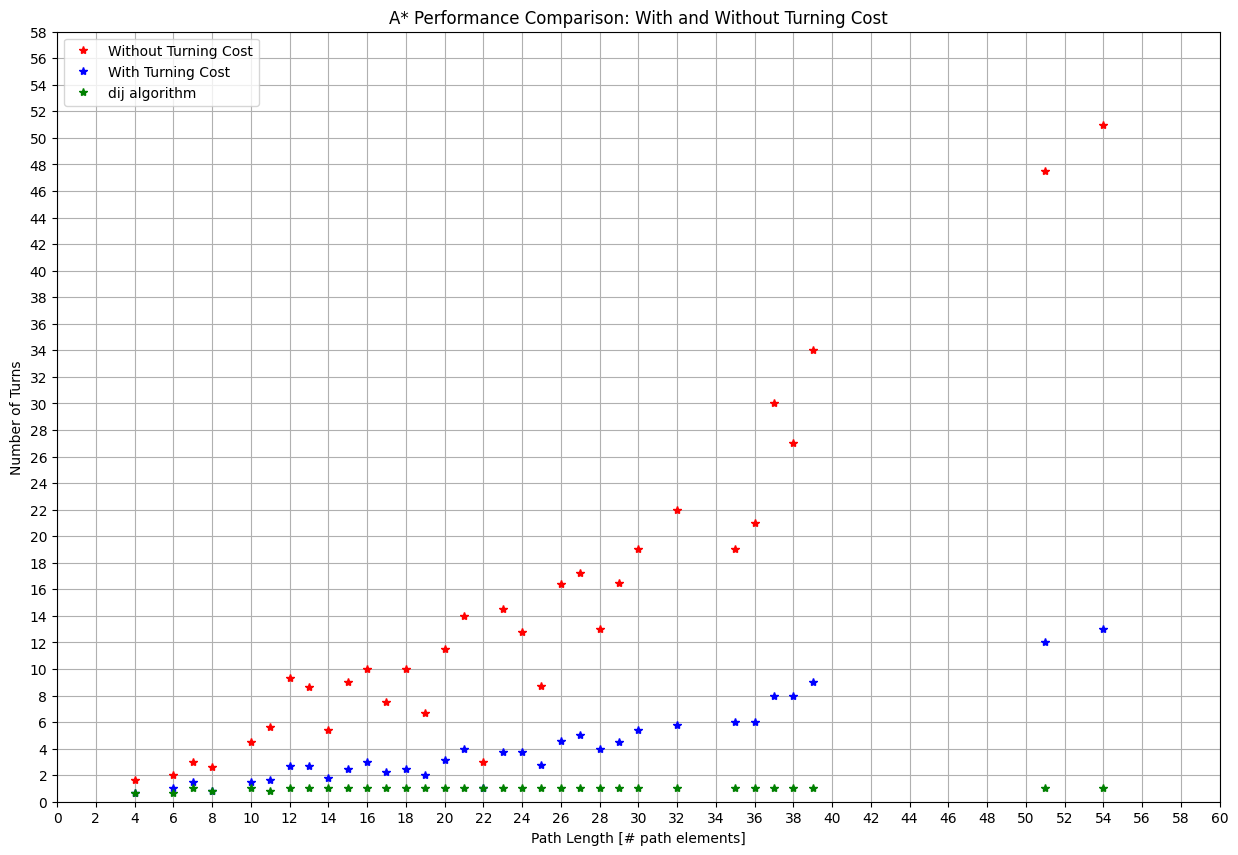

 Average number of iterations needed to find one grid element of the lowest-cost path (i.e. path element), for different path lengths, for a 30 × 30 rectangular grid with 0% of the grid elements blocked


In [22]:
import matplotlib.pyplot as plt

# Collecting the x and y values from avg_result
x_vals = [result[0] for result in avg_result]
y_vals_no_turn = [result[1] for result in avg_result]

y_vals_with_turn = [result[2] for result in avg_result]
y_dij = [result[3] for result in avg_result]
# Create a new figure with a rectangular shape
plt.figure(figsize=(15, 10))  # Adjust width and height for rectangular plot

# Plot the red line for 'Without Turning Cost'
plt.plot(x_vals, y_vals_no_turn, 'r*', label='Without Turning Cost')  # Red '*' markers

# Plot the blue line for 'With Turning Cost'
plt.plot(x_vals, y_vals_with_turn, 'b*', label='With Turning Cost')   # Blue '*' markers

plt.plot(x_vals, y_dij, 'g*', label='dij algorithm')   # Blue '*' markers

# Adding labels and title
plt.xlabel('Path Length [# path elements]')
plt.ylabel('Number of Turns')
plt.title('A* Performance Comparison: With and Without Turning Cost')

# Fine-tune axis limits
plt.xlim([0, 60])  # Set x-axis range
plt.ylim([0, 25])  # Set y-axis range based on example

# Customize ticks to reflect the scale shown in your example
plt.xticks(range(0, 61, 2))  # x-axis ticks from 0 to 60, step size of 5
plt.yticks(range(0, 60, 2))  # y-axis ticks from 0 to 25, step size of 2

# Add grid lines for better readability
plt.grid(True)

# Show legend to differentiate the lines
plt.legend(loc='upper left')

# Display the plot
plt.show()

print(" Average number of iterations needed to find one grid element of the lowest-cost path (i.e. path element), for different path lengths, for a 30 × 30 rectangular grid with 0% of the grid elements blocked")


In [23]:
avg_resultz = []
total_no_turn1 = 0.0
no_turn_counter1 = 0

dij_counter1 = 0
total_dij1 = 0.0

total_turn1 = 0.0
turn_counter1 = 0

curr_len1 = sorted_listz[0][0]  # Initialize with the first length

for result in sorted_listz:
    if result[0] == curr_len1:
        total_no_turn1 += result[1]
        no_turn_counter1 += 1
        
        total_turn1 += result[2]
        turn_counter1 += 1
        
        total_dij1 += result[3]
        dij_counter1 += 1
    else:
        avg_resultz.append((curr_len1, total_no_turn1 / no_turn_counter1, total_turn1 / turn_counter1, total_dij1 / dij_counter1))
        
        # Reset counters and variables
        curr_len1 = result[0]
        total_turn1 = result[2]  # Initialize with the current values
        total_no_turn1 = result[1]
        no_turn_counter1 = 1
        turn_counter1 = 1
        total_dij1  = result[3]
        dij_counter1 = 1

# Append the last group of averages
avg_resultz.append((curr_len1, total_no_turn1 / no_turn_counter1, total_turn1 / turn_counter1, total_dij1 / dij_counter1))

print(avg_resultz)
print(len(avg_result))
print(len(avg_resultz))


[(4, 6.333333333333333, 6.666666666666667, 31.333333333333332), (6, 11.333333333333334, 12.333333333333334, 60.0), (7, 17.5, 20.0, 80.0), (8, 17.8, 19.0, 101.6), (10, 31.5, 37.333333333333336, 155.16666666666666), (11, 38.2, 48.6, 211.8), (12, 56.333333333333336, 72.0, 265.0), (13, 62.666666666666664, 78.0, 274.0), (14, 53.2, 67.0, 259.2), (15, 72.0, 88.0, 242.0), (16, 90.0, 111.0, 424.0), (17, 76.75, 96.5, 361.75), (18, 102.0, 124.5, 372.0), (19, 70.33333333333333, 81.33333333333333, 428.3333333333333), (20, 124.33333333333333, 152.5, 556.8333333333334), (21, 150.33333333333334, 186.0, 518.3333333333334), (22, 79.0, 101.5, 511.0), (23, 158.75, 192.0, 544.25), (24, 167.0, 201.5, 520.5), (25, 142.75, 176.5, 550.25), (26, 218.4, 268.2, 739.2), (27, 227.0, 275.25, 676.75), (28, 235.0, 282.0, 681.0), (29, 256.5, 309.5, 832.0), (30, 280.8, 339.6, 732.8), (32, 313.25, 369.75, 750.75), (35, 372.0, 444.0, 764.0), (36, 414.5, 490.5, 862.0), (37, 498.0, 582.0, 896.0), (38, 509.0, 600.0, 897.0), 

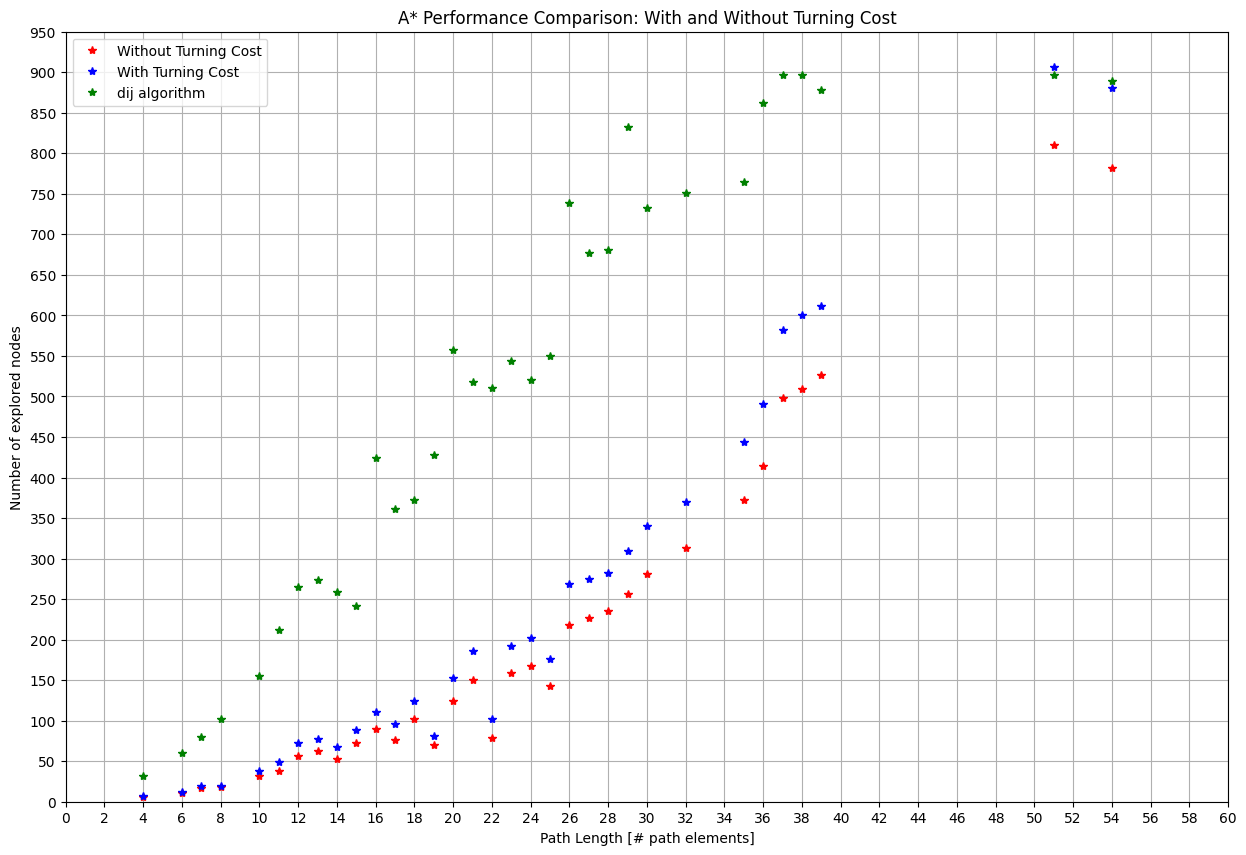

 Average number of iterations needed to find one grid element of the lowest-cost path (i.e. path element), for different path lengths, for a 30 × 30 rectangular grid with 0% of the grid elements blocked


In [24]:
import matplotlib.pyplot as plt

# Collecting the x and y values from avg_result
x_vals = [result[0] for result in avg_resultz]
y_vals_no_turn = [result[1] for result in avg_resultz]

y_vals_with_turn = [result[2] for result in avg_resultz]
y_dij = [result[3] for result in avg_resultz]
# Create a new figure with a rectangular shape
plt.figure(figsize=(15, 10))  # Adjust width and height for rectangular plot

# Plot the red line for 'Without Turning Cost'
plt.plot(x_vals, y_vals_no_turn, 'r*', label='Without Turning Cost')  # Red '*' markers

# Plot the blue line for 'With Turning Cost'
plt.plot(x_vals, y_vals_with_turn, 'b*', label='With Turning Cost')   # Blue '*' markers

plt.plot(x_vals, y_dij, 'g*', label='dij algorithm')   # Blue '*' markers

# Adding labels and title
plt.xlabel('Path Length [# path elements]')
plt.ylabel('Number of explored nodes')
plt.title('A* Performance Comparison: With and Without Turning Cost')

# Fine-tune axis limits
plt.xlim([0, 60])  # Set x-axis range
plt.ylim([0, 900])  # Set y-axis range based on example

# Customize ticks to reflect the scale shown in your example
plt.xticks(range(0, 61, 2))  # x-axis ticks from 0 to 60, step size of 5
plt.yticks(range(0, 951, 50))  # y-axis ticks from 0 to 25, step size of 2

# Customize ticks to reflect the scale shown in your example


# Add grid lines for better readability
plt.grid(True)

# Show legend to differentiate the lines
plt.legend(loc='upper left')

# Display the plot
plt.show()

print(" Average number of iterations needed to find one grid element of the lowest-cost path (i.e. path element), for different path lengths, for a 30 × 30 rectangular grid with 0% of the grid elements blocked")


ValueError: x and y must have same first dimension, but have shapes (100,) and (33,)

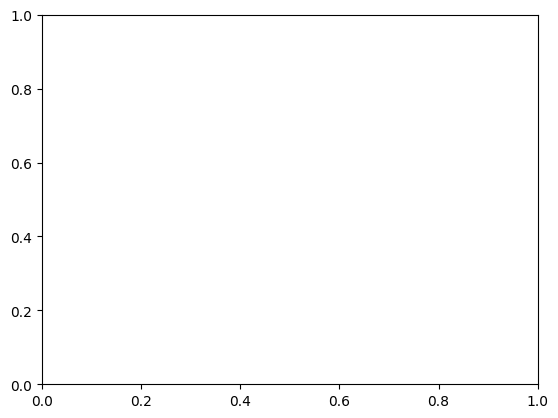

In [29]:
import matplotlib.pyplot as plt

# Collecting the x and y values from avg_result

y_vals_no_turn2 = [result[1] for result in avg_result]

y_vals_with_turn2 = [result[2] for result in avg_result]
y_dij2 = [result[3] for result in avg_result]


y_vals_no_turn1 = [result[1] for result in avg_resultz]

y_vals_with_turn1 = [result[2] for result in avg_resultz]
y_dij1 = [result[3] for result in avg_resultz]


x_vals = [result[0] for result in resultz]

y_vals_no_turn = [a * b for a, b in zip(y_vals_no_turn2, y_vals_no_turn1)]

y_vals_with_turn = [a * b for a, b in zip(y_vals_with_turn2, y_vals_with_turn1)]

y_dij = [a * b for a, b in zip(y_dij1, y_dij2)]
# Create a new figure with a rectangular shape


# Plot the red line for 'Without Turning Cost'
plt.plot(x_vals, y_vals_no_turn, 'r*', label='Without Turning Cost')  # Red '*' markers

# Plot the blue line for 'With Turning Cost'
plt.plot(x_vals, y_vals_with_turn, 'b*', label='With Turning Cost')   # Blue '*' markers

plt.plot(x_vals, y_dij, 'g*', label='dij algorithm')   # Blue '*' markers

# Adding labels and title
plt.xlabel('Path Length [# path elements]')
plt.ylabel('Peformance score')
plt.title('A* Performance Comparison: With and Without Turning Cost')


# Add grid lines for better readability
plt.grid(True)

# Show legend to differentiate the lines
plt.legend(loc='upper left')

# Display the plot
plt.show()

print(" Average number of iterations needed to find one grid element of the lowest-cost path (i.e. path element), for different path lengths, for a 30 × 30 rectangular grid with 0% of the grid elements blocked")
